In [51]:
%pylab inline
%config Inline.Backend.figure_format = 'retina'

from __future__ import division, print_function
import gwmemory
!pip install lalsuite 

from pycbc import catalog
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.fft import fft

import numpy as np
import scipy as sp
import pylab
from scipy.fftpack import fft, rfft

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform
from pycbc.filter.matchedfilter import match

from scipy import signal
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json
import matplotlib.lines as mlines

Populating the interactive namespace from numpy and matplotlib


/home/pycbc/pycbc-software/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rfft', 'pylab', 'psd', 'fft']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [52]:
# Function to calculate the noise weighted inner product of two vectors
# a and b (FFTs) with noise vector Sn (PSD); df = freq. bin size.a, b, and Sn must be same length
def InnerProduct(a, b, Sn, df):
    
    b_conj = np.conjugate(b)
    
    integrand = []
    
    for i in range(0,len(a)):
        intgrnd = a[i]*b_conj[i]/Sn[i]
        integrand.append(intgrnd)
            
    result_complex = 4*np.sum(integrand)*df
    
    result = np.real(result_complex)
    
    return result

In [53]:
#Function to calculate the likelihood of data given parameters of data, template(h_theta), Sn(PSD), and df = freq bin size
#h_theta, data, and Sn (PSD) must all be same length

def LogLikelihood(data, h_theta, Sn, df):
    
    h_minus_d = h_theta - data
    
    term = (-1.0/2)*InnerProduct(h_minus_d, h_minus_d, Sn, df)
    
    result = (term)

    return result

<type 'dict'>
['__call__', '__class__', '__cmp__', '__delattr__', '__doc__', '__format__', '__func__', '__get__', '__getattribute__', '__hash__', '__init__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'im_class', 'im_func', 'im_self']
10001
10001


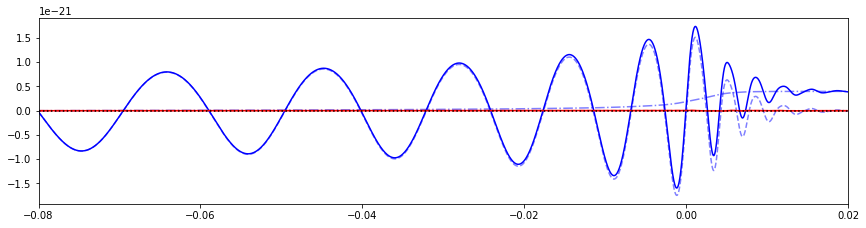

In [63]:
#In order to generate the memory we necessarily generate the time-domain oscillatory waveform
q = 1.
S1 = [0., 0., 0.]
S2 = [0., 0., 0.]

times = np.linspace(-0.08, 0.02, 10001)
#times = np.linspace(-1.8, .1, 10000)
surr = gwmemory.waveforms.Surrogate(q=q, S1=S1, S2=S2, MTot=60, distance=200, times=times)



inc = np.pi / 2
pol = 0

oscillatory, times = surr.time_domain_oscillatory(inc=inc, pol=pol)
memory, times = surr.time_domain_memory(inc=inc, pol=pol)

fig = figure(figsize=(12, 6))
fig.add_subplot(2, 1, 1)
plot(times, oscillatory['plus'], linestyle='--', color='b', alpha=0.5)
plot(times, oscillatory['cross'], linestyle='--', color='r', alpha=0.5)
plot(times, memory['plus'], linestyle='-.', color='b', alpha=0.5)
plot(times, memory['cross'], linestyle='-.', color='r', alpha=0.5)
plot(times, oscillatory['plus'] + memory['plus'], color='b')
plot(times, oscillatory['cross'] + memory['cross'], color='r')
axhline(0, linestyle=':', color='k')
xlim(-0.08, 0.02)

print (type (oscillatory))

print (dir(surr.time_domain_oscillatory))

print (len(times))

print (times.size)


tight_layout()
show()
close()

In [64]:
mem_plus = memory['plus']
dt = times[1] - times[0]
window = signal.tukey(len(mem_plus))
win_mem= window*mem_plus
print (len(win_mem))
print(len(times))
freq_mem = np.fft.rfft(win_mem)*dt

dt = times[1] - times[0]
#print (help(np.fft.fftfreq))
fft_mem = np.fft.rfftfreq (len(win_mem),dt)                            
print (win_mem[0:10])
print (win_mem[50:60])
print (len(freq_mem))
print (len(fft_mem))

10001
10001
[  0.00000000e+00   2.51556526e-33   1.50954303e-32   4.52930136e-32
   1.00666599e-31   1.88779310e-31   3.17199083e-31   4.93498649e-31
   7.25255502e-31   1.02005187e-30]
[  1.61546816e-28   1.71392605e-28   1.81631390e-28   1.92270928e-28
   2.03318976e-28   2.14783295e-28   2.26671651e-28   2.38991809e-28
   2.51751538e-28   2.64958610e-28]
5001
5001


In [65]:
osci_plus = oscillatory['plus']
window = signal.tukey(len(osci_plus))
win_osc= window*osci_plus
freq_osc = np.fft.rfft(win_osc)*dt

fft_osc = np.fft.rfftfreq(len(win_osc), dt)                            
print (win_osc[0:10])
print (win_osc[50:60])
print (len(fft_osc))
print (len(freq_osc))

[ -0.00000000e+00  -1.14057711e-29  -4.91551898e-29  -1.18548857e-28
  -2.24890509e-28  -3.73486868e-28  -5.69647489e-28  -8.18684609e-28
  -1.12591300e-27  -1.49664980e-27]
[ -1.37117523e-25  -1.44963939e-25  -1.53102417e-25  -1.61538217e-25
  -1.70276593e-25  -1.79322796e-25  -1.88682068e-25  -1.98359649e-25
  -2.08360770e-25  -2.18690657e-25]
5001
5001


In [66]:
s = freq_osc + freq_mem

In [11]:
!pip install lalsuite pycbc

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
import pycbc.psd
import pycbc.types
import pylab
from pycbc import catalog
from pycbc import psd
from pycbc import events

filename = 'example_psd.txt'


fn = 'aligo-design.txt'
freqs, asd = np.recfromtxt(asd_fn, unpack='True')
asd_interp = interp1d(freqs, asd)

# The PSD will be interpolated to the requested frequency spacing
delta_f = 1.0 / 4
C
low_frequency_cutoff = 30.0
psd = pycbc.psd.from_txt(filename, length, delta_f,
                         low_frequency_cutoff, is_asd_file=False)
pylab.loglog(psd.sample_frequencies, psd, label='interpolated')

# The PSD will be read in without modification
psd = pycbc.types.load_frequencyseries('./example_psd.txt')
pylab.loglog(psd.sample_frequencies, psd, label='raw')

pylab.xlim(xmin=30, xmax=1000)
pylab.legend()
pylab.xlabel('Hz')
pylab.show()

# Save a psd to file, several formats are supported (.txt, .hdf, .npy)
psd.save('tmp_psd.txt'

['AdVBNSOptimizedSensitivityP1200087', 'AdVDesignSensitivityP1200087', 'AdVEarlyHighSensitivityP1200087', 'AdVEarlyLowSensitivityP1200087', 'AdVLateHighSensitivityP1200087', 'AdVLateLowSensitivityP1200087', 'AdVMidHighSensitivityP1200087', 'AdVMidLowSensitivityP1200087', 'AdvVirgo', 'GEO', 'GEOHF', 'KAGRA', 'KAGRADesignSensitivityT1600593', 'KAGRAEarlySensitivityT1600593', 'KAGRALateSensitivityT1600593', 'KAGRAMidSensitivityT1600593', 'KAGRAOpeningSensitivityT1600593', 'TAMA', 'Virgo', 'aLIGOBHBH20Deg', 'aLIGOBHBH20DegGWINC', 'aLIGOBNSOptimizedSensitivityP1200087', 'aLIGODesignSensitivityP1200087', 'aLIGOEarlyHighSensitivityP1200087', 'aLIGOEarlyLowSensitivityP1200087', 'aLIGOHighFrequency', 'aLIGOHighFrequencyGWINC', 'aLIGOLateHighSensitivityP1200087', 'aLIGOLateLowSensitivityP1200087', 'aLIGOMidHighSensitivityP1200087', 'aLIGOMidLowSensitivityP1200087', 'aLIGONSNSOpt', 'aLIGONSNSOptGWINC', 'aLIGONoSRMHighPower', 'aLIGONoSRMLowPower', 'aLIGONoSRMLowPowerGWINC', 'aLIGOQuantumBHBH20Deg'

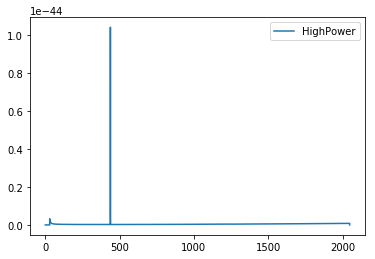

In [28]:
import pycbc.psd
import pylab

# List the available analytic psds
print(pycbc.psd.get_lalsim_psd_list())

delta_f = 1.0 / 16
flen = int(2048 / delta_f)
low_frequency_cutoff = 30.0

# One can either call the psd generator by name
#p1 = pycbc.psd.AdVDesignSensitivityP1200087(flen, delta_f, low_frequency_cutoff)

# or by using the name as a string.
p2 = pycbc.psd.from_string('AdVDesignSensitivityP1200087', flen, delta_f, low_frequency_cutoff)

pylab.plot(p1.sample_frequencies, p1, label='HighPower')
#pylab.plot(p2.sample_frequencies, p2, label='LowPower')
pylab.legend()
pylab.show()

['AdVBNSOptimizedSensitivityP1200087', 'AdVDesignSensitivityP1200087', 'AdVEarlyHighSensitivityP1200087', 'AdVEarlyLowSensitivityP1200087', 'AdVLateHighSensitivityP1200087', 'AdVLateLowSensitivityP1200087', 'AdVMidHighSensitivityP1200087', 'AdVMidLowSensitivityP1200087', 'AdvVirgo', 'FrequencySeries', 'GEO', 'GEOHF', 'KAGRA', 'KAGRADesignSensitivityT1600593', 'KAGRAEarlySensitivityT1600593', 'KAGRALateSensitivityT1600593', 'KAGRAMidSensitivityT1600593', 'KAGRAOpeningSensitivityT1600593', 'TAMA', 'Virgo', '__builtins__', '__doc__', '__file__', '__name__', '__package__', '_name', '_name_blacklist', '_name_prefix', '_name_suffix', '_psd_list', 'aLIGOBHBH20Deg', 'aLIGOBHBH20DegGWINC', 'aLIGOBNSOptimizedSensitivityP1200087', 'aLIGODesignSensitivityP1200087', 'aLIGOEarlyHighSensitivityP1200087', 'aLIGOEarlyLowSensitivityP1200087', 'aLIGOHighFrequency', 'aLIGOHighFrequencyGWINC', 'aLIGOLateHighSensitivityP1200087', 'aLIGOLateLowSensitivityP1200087', 'aLIGOMidHighSensitivityP1200087', 'aLIGOMi

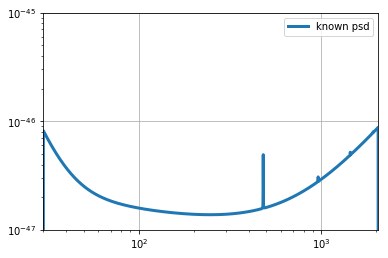

In [74]:
import pycbc.noise
import pycbc.psd
import pylab
from pycbc import catalog
from pycbc import psd
from pycbc import events


# generate some colored gaussian noise
low_freq_cutoff = 30.0
delta_f = 1.0 / 16
#delta_f = 1.0 / 4
length = int(2048 / delta_f) + 1
#length = int(1024 / delta_f)
print (dir(pycbc.psd.analytical))
psd = pycbc.psd.analytical.aLIGODesignSensitivityP1200087(length, delta_f, low_freq_cutoff)
#print (dir(pycbc.psd.analytical))

### Generate 128 seconds of noise at 4096 Hz
delta_t = 1.0 / 4096
tsamples = int(128 / delta_t)
ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)

# Estimate the PSD
## We'll choose 4 seconds PSD samples that are overlapped 50 %
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)
estimated_psd = pycbc.psd.welch(ts,
                      seg_len=seg_len,
                      seg_stride=seg_stride)

#pylab.loglog(estimated_psd.sample_frequencies, estimated_psd, label='estimate')
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='known psd')
pylab.xlim(xmin=30, xmax=2048)
pylab.ylim(1e-47, 1e-45)
pylab.legend()
pylab.grid()
pylab.show()

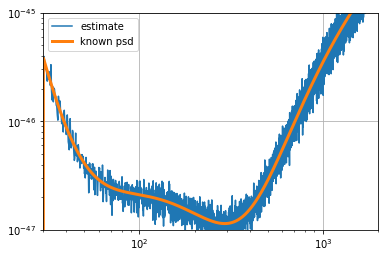

In [77]:

#print (dir(pycbc.psd.analytical))
#psd = pycbc.psd.analytical.import pycbc.noise
import pycbc.psd
import pylab
from pycbc import catalog
from pycbc import psd
from pycbc import events


# generate some colored gaussian noise
low_freq_cutoff = 30.0
delta_f = 1.0 / 16
#delta_f = 1.0 / 4
length = int(2048 / delta_f) + 1
#length = int(1024 / delta_f)
#print (dir(pycbc.psd.analytical))
psd = pycbc.psd.analytical.AdvVirgo(length, delta_f, low_freq_cutoff)
#print (dir(pycbc.psd.analytical))

### Generate 128 seconds of noise at 4096 Hz
delta_t = 1.0 / 4096
tsamples = int(128 / delta_t)
ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)

# Estimate the PSD
## We'll choose 4 seconds PSD samples that are overlapped 50 %
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)
estimated_psd = pycbc.psd.welch(ts,
                      seg_len=seg_len,
                      seg_stride=seg_stride)

pylab.loglog(estimated_psd.sample_frequencies, estimated_psd, label='estimate')
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='known psd')
pylab.xlim(xmin=30, xmax=2000)
pylab.ylim(1e-47, 1e-45)
pylab.legend()
pylab.grid()
pylab.show()
#print (dir(pycbc.psd.analytical))



In [78]:
asd = np.sqrt(psd)
asd_freqs = psd.sample_frequencies

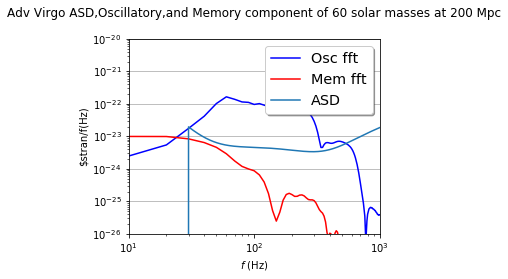

In [80]:
#Creating graph of the signal with the asd, memory, and oscillatory component combined
colours = ['r', 'b', 'g', 'k']

plt.figure()
plt.loglog(np.absolute(fft_osc),np.absolute(freq_osc*(sqrt(fft_osc))), linestyle='-', color='b', label='Osc fft')
plt.loglog(np.absolute(fft_mem),np.absolute(freq_mem*(sqrt(fft_osc))), linestyle='-', color='r', label='Mem fft')

         
#plotting asd
plt.loglog(asd_freqs,asd, label = 'ASD')
plt.legend(loc='upper right', shadow=True, fontsize='x-large')

xlabel('$f$ (Hz)')
ylabel('$stran/f(Hz)')

xlim(10, 1000)
ylim(1e-26, 1e-20)

ax = plt.gca()
ax.grid(True, axis='y')

plt.title("Adv Virgo ASD,Oscillatory,and Memory component of 60 solar masses at 200 Mpc", y=1.08)
tight_layout()
show()
close()

In [14]:
#Interpolating to make  memory and oscillatory component (in freq domain) and PSD equal. This will line them up
from scipy.interpolate import interp1d
sampfreq = 4096
datafreq = np.fft.fftfreq(freq_osc.size)*sampfreq
interpolate_psd = np.interp(datafreq, asd_freqs, psd)

In [15]:
#Template, adding in the lambda component. Will store log likelihood of the template
lambda_arr = np.arange(-10,10,.1)
like_arr = []
for weight in lambda_arr:
    h_trial = freq_osc + weight*freq_mem
    like_trial = LogLikelihood(s, h_trial, interpolate_psd, df)
    like_arr.append(like_trial)

In [16]:
#Normalizing the Likelihood array
likelihood1 = np.exp(asarray(like_arr))
Normal = likelihood1.sum()*.1
Norm = likelihood1/Normal
print (Normal)
print (Norm)


19.9833321912
[ 0.04989526  0.04989791  0.04990053  0.04990313  0.0499057   0.04990825
  0.04991078  0.04991328  0.04991576  0.04991822  0.04992065  0.04992305
  0.04992543  0.04992779  0.04993013  0.04993244  0.04993472  0.04993698
  0.04993922  0.04994144  0.04994362  0.04994579  0.04994793  0.04995005
  0.04995214  0.04995421  0.04995626  0.04995828  0.04996027  0.04996224
  0.04996419  0.04996612  0.04996802  0.04996989  0.04997175  0.04997357
  0.04997538  0.04997716  0.04997891  0.04998064  0.04998235  0.04998403
  0.04998569  0.04998733  0.04998894  0.04999052  0.04999208  0.04999362
  0.04999513  0.04999662  0.04999809  0.04999953  0.05000095  0.05000234
  0.05000371  0.05000505  0.05000637  0.05000767  0.05000894  0.05001019
  0.05001141  0.05001261  0.05001379  0.05001494  0.05001606  0.05001717
  0.05001824  0.0500193   0.05002033  0.05002133  0.05002232  0.05002327
  0.05002421  0.05002511  0.050026    0.05002686  0.05002769  0.05002851
  0.05002929  0.05003006  0.0500308  

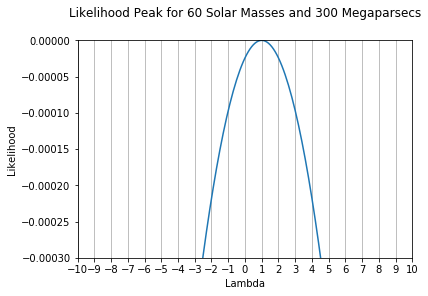

In [20]:
#Plotting the normalized likelihood array
import pylab
import numpy

x = lambda_arr 
y = np.asarray(like_arr)
#pylab.semilogy(x,y) 
pylab.plot(x,y)
pylab.xlim(-10, 10, 0.01)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.gca().xaxis.grid(True)
pylab.xlabel('Lambda')
pylab.ylim(-.0003, .000, 0.001)
pylab.ylabel('Likelihood')
plt.title("Likelihood Peak for 60 Solar Masses and 300 Megaparsecs", y=1.08)

 
pylab.show() 

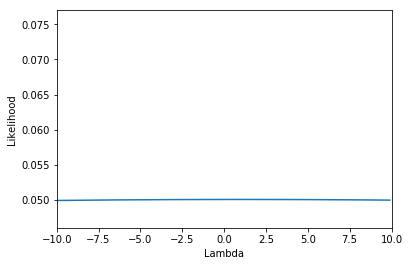

In [424]:
#Plotting the normalized likelihood array
import pylab
import numpy

x = lambda_arr 
y = Norm
#pylab.semilogy(x,y) 
pylab.plot(x,y)
pylab.xlim(-10, 10, 0.01)
pylab.xlabel('Lambda')
pylab.ylim(.046, .077, 0.01)
pylab.ylabel('Likelihood')
#plt.title("Likelihood for 60 solar massess and 5 megaparsecs", y=1.08)

 
pylab.show() 

In [428]:
import pycbc.psd
import pycbc.types
import pylab

filename = 'example_psd.txt'

# The PSD will be interpolated to the requested frequency spacing
delta_f = 1.0 / 4
length = int(1024 / delta_f)
low_frequency_cutoff = 30.0
#psd = pycbc.psd.analytical.EinsteinTelescopeP1600143(length, delta_f, low_freq_cutoff)
psd = pycbc.psd.from_txt(filename, length, delta_f,
                         low_frequency_cutoff, is_asd_file=False)
pylab.loglog(psd.sample_frequencies, psd, label='interpolated')

# The PSD will be read in without modification
psd = pycbc.types.load_frequencyseries('./example_psd.txt')
pylab.loglog(psd.sample_frequencies, psd, label='raw')

pylab.xlim(xmin=30, xmax=1000)
pylab.legend()
pylab.xlabel('Hz')
pylab.show()

IOError: [Errno 2] No such file or directory: 'example_psd.txt'